In [273]:
import pandas as pd
import numpy as np
from faker import Faker
import random
import datetime
import boto3
import psycopg2
import configparser
import matplotlib.pyplot as plt

In [12]:
config = configparser.ConfigParser()
config.read('config.cfg')

['config.cfg']

### CREACION DE INSTANCIAS EN RDS

In [4]:
aws_conn = boto3.client('rds', aws_access_key_id=config.get('IAM', 'ACCESS_KEY'),
                    aws_secret_access_key=config.get('IAM', 'SECRET_ACCESS_KEY'),
                    region_name='us-east-1')

### VERIFICACION DE INSTANCIAS EN RDS

In [5]:
rdsInstanceIds = []

response = aws_conn.describe_db_instances()
for resp in response['DBInstances']:
    rdsInstanceIds.append(resp['DBInstanceIdentifier'])
    db_instance_status = resp['DBInstanceStatus']

print(f"DBInstanceIds {rdsInstanceIds}")

DBInstanceIds []


In [6]:
rds1Identifier = 'OLTP'

### CREACION DE LOS SERVICIOS EN RDS PARA EL OLTP

In [9]:
try:
    response = aws_conn.create_db_instance(
            AllocatedStorage=10,
            DBName=config.get('OLTP', 'DB_NAME'),
            DBInstanceIdentifier=rds1Identifier,
            DBInstanceClass="db.t3.micro",
            Engine="postgres",
            MasterUsername=config.get('OLTP', 'DB_USER'),
            MasterUserPassword=config.get('OLTP', 'DB_PASSWORD'),
            Port=int(config.get('OLTP', 'DB_PORT')),
            VpcSecurityGroupIds=[config.get('VPC', 'SECURITY_GROUP')],
            PubliclyAccessible=True
        )
    print(response)
except aws_conn.exceptions.DBInstanceAlreadyExistsFault as ex:
    print("La Instancia de Base de Datos ya Existe.")

{'DBInstance': {'DBInstanceIdentifier': 'oltp', 'DBInstanceClass': 'db.t3.micro', 'Engine': 'postgres', 'DBInstanceStatus': 'creating', 'MasterUsername': 'postgres', 'DBName': 'OLTP', 'AllocatedStorage': 10, 'PreferredBackupWindow': '03:02-03:32', 'BackupRetentionPeriod': 1, 'DBSecurityGroups': [], 'VpcSecurityGroups': [{'VpcSecurityGroupId': 'sg-008e1623a182fda6c', 'Status': 'active'}], 'DBParameterGroups': [{'DBParameterGroupName': 'default.postgres14', 'ParameterApplyStatus': 'in-sync'}], 'DBSubnetGroup': {'DBSubnetGroupName': 'default', 'DBSubnetGroupDescription': 'default', 'VpcId': 'vpc-0e9ad43e5e102799b', 'SubnetGroupStatus': 'Complete', 'Subnets': [{'SubnetIdentifier': 'subnet-05fa9ae41a65d125b', 'SubnetAvailabilityZone': {'Name': 'us-east-1f'}, 'SubnetOutpost': {}, 'SubnetStatus': 'Active'}, {'SubnetIdentifier': 'subnet-05e41800505383ed7', 'SubnetAvailabilityZone': {'Name': 'us-east-1a'}, 'SubnetOutpost': {}, 'SubnetStatus': 'Active'}, {'SubnetIdentifier': 'subnet-093017ed8fc6

### VALIDACION DE CONEXION

In [93]:
try:
     instances = aws_conn.describe_db_instances(DBInstanceIdentifier=rds1Identifier)
     RDS_HOST = instances.get('DBInstances')[0].get('Endpoint').get('Address')
     print(RDS_HOST)
except Exception as ex:
     print("La instancia de base de datos no existe o aun no se ha terminado de crear.")
     print(ex)

oltp.cpvsavu5bx5f.us-east-1.rds.amazonaws.com


### CREACION DE TABLAS REGISTRO DE TRANSACCIONES

In [15]:
import SQL_OLTP

try:
    db_conn = psycopg2.connect(
        database=config.get('OLTP', 'DB_NAME'), 
        user=config.get('OLTP', 'DB_USER'),
        password=config.get('OLTP', 'DB_PASSWORD'), 
        host=RDS_HOST,
        port=config.get('OLTP', 'DB_PORT')
    )

    cursor = db_conn.cursor()
    cursor.execute(SQL_OLTP.DDL_QUERY)
    db_conn.commit()
    print("Base de Datos Creada Exitosamente")
except Exception as ex:
    print("ERROR: Error al crear la base de datos.")
    print(ex)

Base de Datos Creada Exitosamente


In [94]:
def insertDataToSQL(data_dict, table_name):
     postgres_driver = f"""postgresql://{config.get('OLTP', 'DB_USER')}:{config.get('OLTP', 'DB_PASSWORD')}@{RDS_HOST}:{config.get('OLTP', 'DB_PORT')}/{config.get('OLTP', 'DB_NAME')}"""    
     df_data = pd.DataFrame.from_records(data_dict)
     try:
          response = df_data.to_sql(table_name, postgres_driver, index=False, if_exists='append')
          print(f'Se han insertado {response} nuevos registros.' )
     except Exception as ex:
          print(ex)

### CONEXION HACIA AWS S3

In [23]:
s3 = boto3.resource(
    service_name = 's3',
    region_name = 'us-east-1',
    aws_access_key_id = config.get('IAM', 'ACCESS_KEY'),
    aws_secret_access_key = config.get('IAM', 'SECRET_ACCESS_KEY')
)

In [24]:
for bucket in s3.buckets.all():
    S3_BUCKET_NAME = bucket.name
    print(bucket.name)

dspython-2023
proyectodwh2023


In [25]:
S3_BUCKET_NAME = 'dspython-2023'

In [42]:
remoteFileList = []
for objt in s3.Bucket(S3_BUCKET_NAME).objects.all():
    remoteFileList.append(objt.key)

remoteFileList

['CATEGORIA.csv',
 'CLIENTE.csv',
 'DEPARTAMENTO.csv',
 'DEVOLUCIONES.csv',
 'ENVIO.csv',
 'GERENTE.csv',
 'HOLLIDAY.csv',
 'MUNICIPIO.csv',
 'PRODUCTO.csv',
 'REGION.csv',
 'SEGMENTO.csv',
 'STORE.csv',
 'SUBCATEGORIA.csv',
 'VENTAS.csv']

### CARGA DE DATOS OLTP

In [43]:
import io

for remoteFile in remoteFileList:
    try:
        file = s3.Bucket(S3_BUCKET_NAME).Object(remoteFile).get()
        data = file['Body'].read()
        df_categoria = pd.read_csv('CATEGORIA.csv')
    except Exception as ex:
        print("No es un archivo.")
        print(ex)

df_categoria.head()

,categoria_id,categoria
0,MAT,Material de oficina
1,MOB,Mobiliario
2,TEC,Tecnología


In [35]:
insertDataToSQL(df_categoria, 'categoria')

Se han insertado 3 nuevos registros.


In [44]:
import io

for remoteFile in remoteFileList:
    try:
        file = s3.Bucket(S3_BUCKET_NAME).Object(remoteFile).get()
        data = file['Body'].read()
        df_region = pd.read_csv('REGION.csv')
    except Exception as ex:
        print("No es un archivo.")
        print(ex)

df_region.head()

,region_id,region
0,MET,Metropolitana
1,NOR,Norte
2,NRT,Nororiental
3,SUR,Suroriental
4,CNT,Central


In [45]:
insertDataToSQL(df_region, 'region')

Se han insertado 8 nuevos registros.


In [46]:
import io

for remoteFile in remoteFileList:
    try:
        file = s3.Bucket(S3_BUCKET_NAME).Object(remoteFile).get()
        data = file['Body'].read()
        df_departamento = pd.read_csv('DEPARTAMENTO.csv')
    except Exception as ex:
        print("No es un archivo.")
        print(ex)

df_departamento.head()

,departamento_id,region_id,departamento
0,GT-01,MET,Guatemala
1,GT-02,NOR,Alta Verapaz
2,GT-03,NOR,Baja Verapaz
3,GT-04,NRT,Chiquimula
4,GT-05,NRT,El Progreso


In [47]:
insertDataToSQL(df_departamento, 'departamento')

Se han insertado 22 nuevos registros.


In [48]:
import io

for remoteFile in remoteFileList:
    try:
        file = s3.Bucket(S3_BUCKET_NAME).Object(remoteFile).get()
        data = file['Body'].read()
        df_municipio = pd.read_csv('MUNICIPIO.csv')
    except Exception as ex:
        print("No es un archivo.")
        print(ex)

df_municipio.head()

,municipio_id,departamento_id,municipio
0,GT-0101,GT-01,Guatemala
1,GT-0102,GT-01,Santa Catarina Pinula
2,GT-0103,GT-01,San José Pinula
3,GT-0104,GT-01,San José del Golfo
4,GT-0105,GT-01,Palencia


In [49]:
insertDataToSQL(df_municipio, 'municipio')

Se han insertado 329 nuevos registros.


In [50]:
import io

for remoteFile in remoteFileList:
    try:
        file = s3.Bucket(S3_BUCKET_NAME).Object(remoteFile).get()
        data = file['Body'].read()
        df_subcategoria = pd.read_csv('SUBCATEGORIA.csv')
    except Exception as ex:
        print("No es un archivo.")
        print(ex)

df_subcategoria.head()

,subcategoria_id,categoria_id,categoria,subcategoria
0,ET,MAT,Material de oficina,Etiquetas
1,MO,MOB,Mobiliario,Mobiliario
2,LI,MOB,Mobiliario,Librerías
3,CA,MAT,Material de oficina,Carpetas
4,AR,MAT,Material de oficina,Arte


In [51]:
insertDataToSQL(df_subcategoria, 'subcategoria')

Se han insertado 17 nuevos registros.


In [52]:
import io

for remoteFile in remoteFileList:
    try:
        file = s3.Bucket(S3_BUCKET_NAME).Object(remoteFile).get()
        data = file['Body'].read()
        df_producto = pd.read_csv('PRODUCTO.csv')
    except Exception as ex:
        print("No es un archivo.")
        print(ex)

df_producto.head()

,producto_id,categoria_id,subcategoria_id,nombre_del_producto
0,MAT-ET-10000866,MAT,ET,"Hon Etiquetas para carpetas de archivos, Ajust..."
1,MOB-MO-10000543,MOB,MO,"Tenex Reloj, Duradero"
2,MOB-LI-10000111,MOB,LI,"Ikea Vitrina, Blanco"
3,MAT-CA-10004211,MAT,CA,"Cardinal Carpeta, Transparente"
4,MAT-AR-10001135,MAT,AR,"Sanford Lienzos, Tamaños variados"


In [53]:
insertDataToSQL(df_producto, 'producto')

Se han insertado 186 nuevos registros.


In [54]:
import io

for remoteFile in remoteFileList:
    try:
        file = s3.Bucket(S3_BUCKET_NAME).Object(remoteFile).get()
        data = file['Body'].read()
        df_segmento = pd.read_csv('SEGMENTO.csv')
    except Exception as ex:
        print("No es un archivo.")
        print(ex)

df_segmento.head()

,segmento_id,segmento
0,CL,Cliente
1,PE,Pequeña empresa
2,ME,Empresa


In [55]:
insertDataToSQL(df_segmento, 'segmento')

Se han insertado 3 nuevos registros.


In [56]:
import io

for remoteFile in remoteFileList:
    try:
        file = s3.Bucket(S3_BUCKET_NAME).Object(remoteFile).get()
        data = file['Body'].read()
        df_cliente = pd.read_csv('CLIENTE.csv')
    except Exception as ex:
        print("No es un archivo.")
        print(ex)

df_cliente.head()

,cliente_id,nombre_del_cliente,segmento_id,region_id,departamento_id,municipio_id
0,RC-20575,Reyes Coto,CL,MET,GT-01,GT-0101
1,IG-16570,Iván Girón,CL,MET,GT-01,GT-0102
2,CV-13000,Cristina Vázquez,CL,MET,GT-01,GT-0107
3,TR-21250,Trinidad Rubio,CL,MET,GT-01,GT-0112
4,MG-18910,Mireia Garay,PE,MET,GT-01,GT-0114


In [57]:
insertDataToSQL(df_cliente, 'cliente')

Se han insertado 794 nuevos registros.


In [62]:
import io

for remoteFile in remoteFileList:
    try:
        file = s3.Bucket(S3_BUCKET_NAME).Object(remoteFile).get()
        data = file['Body'].read()
        df_gerente = pd.read_csv('GERENTE.csv')
    except Exception as ex:
        print("No es un archivo.")
        print(ex)

df_gerente.head()

,gerente_id,gerente_regional
0,1001,Eva Lara
1,1010,Silvia Pérez
2,1020,Augusto Olivares
3,1023,Gabriela Bustamante
4,1551,Alejandro Villatoro


In [63]:
insertDataToSQL(df_gerente, 'gerente')

Se han insertado 8 nuevos registros.


In [64]:
import io

for remoteFile in remoteFileList:
    try:
        file = s3.Bucket(S3_BUCKET_NAME).Object(remoteFile).get()
        data = file['Body'].read()
        df_store = pd.read_csv('STORE.csv')
    except Exception as ex:
        print("No es un archivo.")
        print(ex)

df_store.head()

,store_id,region_id,gerente_id,store
0,G10,MET,1001,CENTRAL 2
1,G20,NOR,1010,PETEN
2,G30,NRT,1020,IZABAL
3,G40,SUR,1023,ESCUINTLA
4,G50,CNT,1551,CENTRAL 1


In [65]:
insertDataToSQL(df_store, 'store')

Se han insertado 8 nuevos registros.


In [73]:
import io

for remoteFile in remoteFileList:
    try:
        file = s3.Bucket(S3_BUCKET_NAME).Object(remoteFile).get()
        data = file['Body'].read()
        df_envio = pd.read_csv('ENVIO.csv')
    except Exception as ex:
        print("No es un archivo.")
        print(ex)

df_envio.head()

,envio_id,forma_de_envio
0,1001,Estándar
1,1002,Rápido
2,1003,Urgente
3,1004,Mismo día


In [74]:
insertDataToSQL(df_envio, 'envio')

Se han insertado 4 nuevos registros.


In [71]:
import io

for remoteFile in remoteFileList:
    try:
        file = s3.Bucket(S3_BUCKET_NAME).Object(remoteFile).get()
        data = file['Body'].read()
        df_ventas = pd.read_csv('VENTAS.csv')
    except Exception as ex:
        print("No es un archivo.")
        print(ex)

df_ventas.head()

,pedido_id,fecha_pedido,fecha_de_envio,envio_id,cliente_id,store_id,producto_id,total,cantidad,descuento,ganancia
0,GT-2014-1436581,10/2/2014,10/6/2014,1001,RC-20575,G10,MAT-ET-10000866,130.8,3,0.0,45.6
1,GT-2014-1436582,10/15/2012,10/20/2012,1001,IG-16570,G10,MOB-MO-10000543,2521.6,8,0.0,907.2
2,GT-2014-1436583,10/15/2012,10/20/2012,1001,IG-16570,G10,MOB-LI-10000111,1932.8,2,0.0,540.8
3,GT-2014-1436584,10/15/2012,10/20/2012,1001,IG-16570,G10,MAT-CA-10004211,354.4,4,0.0,49.6
4,GT-2014-1436585,10/15/2012,10/20/2012,1001,IG-16570,G10,MAT-AR-10001135,716.0,2,0.0,114.4


In [82]:
insertDataToSQL(df_ventas, 'ventas')

Se han insertado 288 nuevos registros.


In [83]:
import io

for remoteFile in remoteFileList:
    try:
        file = s3.Bucket(S3_BUCKET_NAME).Object(remoteFile).get()
        data = file['Body'].read()
        df_devolucion = pd.read_csv('DEVOLUCIONES.csv')
    except Exception as ex:
        print("No es un archivo.")
        print(ex)

df_devolucion.head()

,pedido_id,devuelto
0,GT-2014-1436581,Sí
1,GT-2014-14365810,Sí
2,GT-2014-143658100,Sí
3,GT-2014-1436581000,Sí
4,GT-2014-14365810000,Sí


In [84]:
insertDataToSQL(df_devolucion, 'devolucion')

Se han insertado 297 nuevos registros.


### CREACION DE LOS RECURSOS EN RDS PARA DATA WAREHOUSE

In [85]:
rds2Identifier = 'DWH'

In [86]:
try:
    response = aws_conn.create_db_instance(
            AllocatedStorage=10,
            DBName=config.get('DWH', 'DB_NAME'),
            DBInstanceIdentifier=rds2Identifier,
            DBInstanceClass="db.t3.micro",
            Engine="postgres",
            MasterUsername=config.get('DWH', 'DB_USER'),
            MasterUserPassword=config.get('DWH', 'DB_PASSWORD'),
            Port=int(config.get('DWH', 'DB_PORT')),
            VpcSecurityGroupIds=[config.get('VPC', 'SECURITY_GROUP')],
            PubliclyAccessible=True
        )
    print(response)
except aws_conn.exceptions.DBInstanceAlreadyExistsFault as ex:
    print("La Instancia de Base de Datos ya Existe.")

{'DBInstance': {'DBInstanceIdentifier': 'dwh', 'DBInstanceClass': 'db.t3.micro', 'Engine': 'postgres', 'DBInstanceStatus': 'creating', 'MasterUsername': 'postgres', 'DBName': 'DWH', 'AllocatedStorage': 10, 'PreferredBackupWindow': '03:52-04:22', 'BackupRetentionPeriod': 1, 'DBSecurityGroups': [], 'VpcSecurityGroups': [{'VpcSecurityGroupId': 'sg-008e1623a182fda6c', 'Status': 'active'}], 'DBParameterGroups': [{'DBParameterGroupName': 'default.postgres14', 'ParameterApplyStatus': 'in-sync'}], 'DBSubnetGroup': {'DBSubnetGroupName': 'default', 'DBSubnetGroupDescription': 'default', 'VpcId': 'vpc-0e9ad43e5e102799b', 'SubnetGroupStatus': 'Complete', 'Subnets': [{'SubnetIdentifier': 'subnet-05fa9ae41a65d125b', 'SubnetAvailabilityZone': {'Name': 'us-east-1f'}, 'SubnetOutpost': {}, 'SubnetStatus': 'Active'}, {'SubnetIdentifier': 'subnet-05e41800505383ed7', 'SubnetAvailabilityZone': {'Name': 'us-east-1a'}, 'SubnetOutpost': {}, 'SubnetStatus': 'Active'}, {'SubnetIdentifier': 'subnet-093017ed8fc6e4

In [171]:
try:
     instances = aws_conn.describe_db_instances(DBInstanceIdentifier=rds2Identifier)
     DWH_HOST = instances.get('DBInstances')[0].get('Endpoint').get('Address')
     print(DWH_HOST)
except Exception as ex:
     print("La instancia de base de datos no existe o aun no se ha terminado de crear.")
     print(ex)

dwh.cpvsavu5bx5f.us-east-1.rds.amazonaws.com


In [260]:
import SQL_DWH

try:
    db_conn = psycopg2.connect(
        database=config.get('DWH', 'DB_NAME'), 
        user=config.get('DWH', 'DB_USER'),
        password=config.get('DWH', 'DB_PASSWORD'), 
        host=DWH_HOST,
        port=config.get('DWH', 'DB_PORT')
    )

    cursor = db_conn.cursor()
    cursor.execute(SQL_DWH.DDL_QUERY)
    db_conn.commit()
    print("Base de Datos Creada Exitosamente")
except Exception as ex:
    print("ERROR: Error al crear la base de datos.")
    print(ex)

Base de Datos Creada Exitosamente


### CREACION DE LAS DIMENSIONES

In [98]:
RDS_HOST = 'oltp.cpvsavu5bx5f.us-east-1.rds.amazonaws.com'
#RDS_HOST=config.get('OLTP', 'RDS_HOST')
#RDS_HOST
print(RDS_HOST)

oltp.cpvsavu5bx5f.us-east-1.rds.amazonaws.com


In [99]:
postgres_driver = f"""postgresql://{config.get('OLTP', 'DB_USER')}:{config.get('OLTP', 'DB_PASSWORD')}@{RDS_HOST}:{config.get('OLTP', 'DB_PORT')}/{config.get('OLTP', 'DB_NAME')}"""  

#### DIMENSION CLIENTES

In [101]:
sql_query = 'SELECT * FROM cliente;'
dw_cliente = pd.read_sql(sql_query, postgres_driver)
dw_cliente.head()

,cliente_id,nombre_del_cliente,segmento_id,region_id,departamento_id,municipio_id
0,RC-20575,Reyes Coto,CL,MET,GT-01,GT-0101
1,IG-16570,Iván Girón,CL,MET,GT-01,GT-0102
2,CV-13000,Cristina Vázquez,CL,MET,GT-01,GT-0107
3,TR-21250,Trinidad Rubio,CL,MET,GT-01,GT-0112
4,MG-18910,Mireia Garay,PE,MET,GT-01,GT-0114


In [102]:
sql_query = 'SELECT * FROM municipio;'
dw_municipio = pd.read_sql(sql_query, postgres_driver)
dw_municipio.head()

,municipio_id,departamento_id,municipio
0,GT-0101,GT-01,Guatemala
1,GT-0102,GT-01,Santa Catarina Pinula
2,GT-0103,GT-01,San José Pinula
3,GT-0104,GT-01,San José del Golfo
4,GT-0105,GT-01,Palencia


In [103]:
dw_cliente_municipio = dw_cliente.merge(dw_municipio, on='municipio_id', how='inner')
dw_cliente_municipio.head()

,cliente_id,nombre_del_cliente,segmento_id,region_id,departamento_id_x,municipio_id,departamento_id_y,municipio
0,RC-20575,Reyes Coto,CL,MET,GT-01,GT-0101,GT-01,Guatemala
1,SB-20830,Sarai Barrientos,CL,MET,GT-01,GT-0101,GT-01,Guatemala
2,AQ-11020,Andrés Quintero,ME,MET,GT-01,GT-0101,GT-01,Guatemala
3,IG-16570,Iván Girón,CL,MET,GT-01,GT-0102,GT-01,Santa Catarina Pinula
4,CM-12460,Casandra Mateo,CL,MET,GT-01,GT-0102,GT-01,Santa Catarina Pinula


In [104]:
sql_query = 'SELECT * FROM departamento;'
dw_departamento = pd.read_sql(sql_query, postgres_driver)
dw_departamento.head()

,departamento_id,region_id,departamento
0,GT-01,MET,Guatemala
1,GT-02,NOR,Alta Verapaz
2,GT-03,NOR,Baja Verapaz
3,GT-04,NRT,Chiquimula
4,GT-05,NRT,El Progreso


In [110]:
dw_cliente_mun_dep = dw_cliente_municipio.merge(dw_departamento, left_on='departamento_id_x', 
                                                                    right_on='departamento_id',  
                                                                    how='inner')
dw_cliente_mun_dep.head()

,cliente_id,nombre_del_cliente,segmento_id,region_id_x,departamento_id_x,municipio_id,departamento_id_y,municipio,departamento_id,region_id_y,departamento
0,RC-20575,Reyes Coto,CL,MET,GT-01,GT-0101,GT-01,Guatemala,GT-01,MET,Guatemala
1,SB-20830,Sarai Barrientos,CL,MET,GT-01,GT-0101,GT-01,Guatemala,GT-01,MET,Guatemala
2,AQ-11020,Andrés Quintero,ME,MET,GT-01,GT-0101,GT-01,Guatemala,GT-01,MET,Guatemala
3,IG-16570,Iván Girón,CL,MET,GT-01,GT-0102,GT-01,Santa Catarina Pinula,GT-01,MET,Guatemala
4,CM-12460,Casandra Mateo,CL,MET,GT-01,GT-0102,GT-01,Santa Catarina Pinula,GT-01,MET,Guatemala


In [111]:
sql_query = 'SELECT * FROM region;'
dw_region = pd.read_sql(sql_query, postgres_driver)
dw_region.head()

,region_id,region
0,MET,Metropolitana
1,NOR,Norte
2,NRT,Nororiental
3,SUR,Suroriental
4,CNT,Central


In [112]:
dw_cliente_region = dw_cliente_mun_dep.merge(dw_region, left_on='region_id_x', 
                                                                    right_on='region_id',  
                                                                    how='inner')
dw_cliente_region.head()

,cliente_id,nombre_del_cliente,segmento_id,region_id_x,departamento_id_x,municipio_id,departamento_id_y,municipio,departamento_id,region_id_y,departamento,region_id,region
0,RC-20575,Reyes Coto,CL,MET,GT-01,GT-0101,GT-01,Guatemala,GT-01,MET,Guatemala,MET,Metropolitana
1,SB-20830,Sarai Barrientos,CL,MET,GT-01,GT-0101,GT-01,Guatemala,GT-01,MET,Guatemala,MET,Metropolitana
2,AQ-11020,Andrés Quintero,ME,MET,GT-01,GT-0101,GT-01,Guatemala,GT-01,MET,Guatemala,MET,Metropolitana
3,IG-16570,Iván Girón,CL,MET,GT-01,GT-0102,GT-01,Santa Catarina Pinula,GT-01,MET,Guatemala,MET,Metropolitana
4,CM-12460,Casandra Mateo,CL,MET,GT-01,GT-0102,GT-01,Santa Catarina Pinula,GT-01,MET,Guatemala,MET,Metropolitana


In [113]:
sql_query = 'SELECT * FROM segmento;'
dw_segmento = pd.read_sql(sql_query, postgres_driver)
dw_segmento.head()

,segmento_id,segmento
0,CL,Cliente
1,PE,Pequeña empresa
2,ME,Empresa


In [175]:
dim_cliente = dw_cliente_region.merge(dw_segmento, on='segmento_id', how='inner')
dim_cliente.drop(['segmento_id', 'region_id_x', 'departamento_id_x', 'municipio_id', 'departamento_id_y', 'departamento_id', 'region_id_y', 'region_id'], axis=1,  inplace=True)
dim_cliente.head()

,cliente_id,nombre_del_cliente,municipio,departamento,region,segmento
0,RC-20575,Reyes Coto,Guatemala,Guatemala,Metropolitana,Cliente
1,SB-20830,Sarai Barrientos,Guatemala,Guatemala,Metropolitana,Cliente
2,IG-16570,Iván Girón,Santa Catarina Pinula,Guatemala,Metropolitana,Cliente
3,CM-12460,Casandra Mateo,Santa Catarina Pinula,Guatemala,Metropolitana,Cliente
4,ÓA-19735,Óscar Alba,Santa Catarina Pinula,Guatemala,Metropolitana,Cliente


#### DIMENSION PRODUCTO

In [127]:
sql_query = 'SELECT * FROM producto;'
dw_producto = pd.read_sql(sql_query, postgres_driver)
dw_producto.head()

,producto_id,categoria_id,subcategoria_id,nombre_del_producto
0,MAT-ET-10000866,MAT,ET,"Hon Etiquetas para carpetas de archivos, Ajust..."
1,MOB-MO-10000543,MOB,MO,"Tenex Reloj, Duradero"
2,MOB-LI-10000111,MOB,LI,"Ikea Vitrina, Blanco"
3,MAT-CA-10004211,MAT,CA,"Cardinal Carpeta, Transparente"
4,MAT-AR-10001135,MAT,AR,"Sanford Lienzos, Tamaños variados"


In [131]:
sql_query = 'SELECT * FROM subcategoria;'
dw_subcategoria = pd.read_sql(sql_query, postgres_driver)
dw_subcategoria.head()

,subcategoria_id,categoria_id,categoria,subcategoria
0,ET,MAT,Material de oficina,Etiquetas
1,MO,MOB,Mobiliario,Mobiliario
2,LI,MOB,Mobiliario,Librerías
3,CA,MAT,Material de oficina,Carpetas
4,AR,MAT,Material de oficina,Arte


In [134]:
dim_producto = dw_producto.merge(dw_subcategoria, on='subcategoria_id', how='inner')
dim_producto.drop(['categoria_id_x', 'subcategoria_id', 'categoria_id_y'], axis=1,  inplace=True)
dim_producto.head()

,producto_id,nombre_del_producto,categoria,subcategoria
0,MAT-ET-10000866,"Hon Etiquetas para carpetas de archivos, Ajust...",Material de oficina,Etiquetas
1,MAT-ET-10004182,"Hon Etiquetas redondas, Blanco",Material de oficina,Etiquetas
2,MAT-ET-10001984,"Avery Etiquetas para documentos legales, Duradero",Material de oficina,Etiquetas
3,MAT-ET-10002124,"Hon Etiquetas para carpetas de archivos, Rojo",Material de oficina,Etiquetas
4,MAT-ET-10001459,"Avery Etiquetas con códigos de color, Rojo",Material de oficina,Etiquetas


#### DIMENSION STORE

In [135]:
sql_query = 'SELECT * FROM store;'
dw_store = pd.read_sql(sql_query, postgres_driver)
dw_store.head()

,store_id,region_id,gerente_id,store
0,G10,MET,1001,CENTRAL 2
1,G20,NOR,1010,PETEN
2,G30,NRT,1020,IZABAL
3,G40,SUR,1023,ESCUINTLA
4,G50,CNT,1551,CENTRAL 1


In [137]:
sql_query = 'SELECT * FROM region;'
dw_region = pd.read_sql(sql_query, postgres_driver)
dw_region.head()

,region_id,region
0,MET,Metropolitana
1,NOR,Norte
2,NRT,Nororiental
3,SUR,Suroriental
4,CNT,Central


In [138]:
dw_store_region = dw_store.merge(dw_region, on='region_id', how='inner')
dw_store_region.head()

,store_id,region_id,gerente_id,store,region
0,G10,MET,1001,CENTRAL 2,Metropolitana
1,G20,NOR,1010,PETEN,Norte
2,G30,NRT,1020,IZABAL,Nororiental
3,G40,SUR,1023,ESCUINTLA,Suroriental
4,G60,SUR,2323,XELA,Suroriental


In [139]:
sql_query = 'SELECT * FROM gerente;'
dw_gerente = pd.read_sql(sql_query, postgres_driver)
dw_gerente.head()

,gerente_id,gerente_regional
0,1001,Eva Lara
1,1010,Silvia Pérez
2,1020,Augusto Olivares
3,1023,Gabriela Bustamante
4,1551,Alejandro Villatoro


In [141]:
dim_store = dw_store_region.merge(dw_gerente, on='gerente_id', how='inner')
dim_store.drop(['region_id', 'gerente_id'], axis=1,  inplace=True)
dim_store.head()

,store_id,store,region,gerente_regional
0,G10,CENTRAL 2,Metropolitana,Eva Lara
1,G20,PETEN,Norte,Silvia Pérez
2,G30,IZABAL,Nororiental,Augusto Olivares
3,G40,ESCUINTLA,Suroriental,Gabriela Bustamante
4,G60,XELA,Suroriental,Pablo Torres


### DIMENSION CIUDAD

In [142]:
sql_query = 'SELECT * FROM municipio;'
dw_municipio = pd.read_sql(sql_query, postgres_driver)
dw_municipio.head()

,municipio_id,departamento_id,municipio
0,GT-0101,GT-01,Guatemala
1,GT-0102,GT-01,Santa Catarina Pinula
2,GT-0103,GT-01,San José Pinula
3,GT-0104,GT-01,San José del Golfo
4,GT-0105,GT-01,Palencia


In [143]:
sql_query = 'SELECT * FROM departamento;'
dw_departamento = pd.read_sql(sql_query, postgres_driver)
dw_departamento.head()

,departamento_id,region_id,departamento
0,GT-01,MET,Guatemala
1,GT-02,NOR,Alta Verapaz
2,GT-03,NOR,Baja Verapaz
3,GT-04,NRT,Chiquimula
4,GT-05,NRT,El Progreso


In [144]:
dw_municipio_dep = dw_municipio.merge(dw_departamento, on='departamento_id', how='inner')
dw_municipio_dep.head()

,municipio_id,departamento_id,municipio,region_id,departamento
0,GT-0101,GT-01,Guatemala,MET,Guatemala
1,GT-0102,GT-01,Santa Catarina Pinula,MET,Guatemala
2,GT-0103,GT-01,San José Pinula,MET,Guatemala
3,GT-0104,GT-01,San José del Golfo,MET,Guatemala
4,GT-0105,GT-01,Palencia,MET,Guatemala


In [145]:
sql_query = 'SELECT * FROM region;'
dw_region = pd.read_sql(sql_query, postgres_driver)
dw_region.head()

,region_id,region
0,MET,Metropolitana
1,NOR,Norte
2,NRT,Nororiental
3,SUR,Suroriental
4,CNT,Central


In [148]:
dim_municipio = dw_municipio_dep.merge(dw_region, on='region_id', how='inner')
dim_municipio.drop(['region_id', 'departamento_id'], axis=1,  inplace=True)
dim_municipio.head()

,municipio_id,municipio,departamento,region
0,GT-0101,Guatemala,Guatemala,Metropolitana
1,GT-0102,Santa Catarina Pinula,Guatemala,Metropolitana
2,GT-0103,San José Pinula,Guatemala,Metropolitana
3,GT-0104,San José del Golfo,Guatemala,Metropolitana
4,GT-0105,Palencia,Guatemala,Metropolitana


#### DIMENSION FECHA

In [225]:
sql_query = 'SELECT fecha_pedido FROM ventas;'
dimFecha = pd.read_sql(sql_query, postgres_driver)
dimFecha.head()

,fecha_pedido
0,2014-10-02
1,2012-10-15
2,2012-10-15
3,2012-10-15
4,2012-10-15


In [231]:
dimFecha['year'] = pd.DatetimeIndex(dimFecha['fecha_pedido']).year
dimFecha['month'] = pd.DatetimeIndex(dimFecha['fecha_pedido']).month
dimFecha['quarter'] = pd.DatetimeIndex(dimFecha['fecha_pedido']).quarter
dimFecha['day'] = pd.DatetimeIndex(dimFecha['fecha_pedido']).day
dimFecha['week'] = pd.DatetimeIndex(dimFecha['fecha_pedido']).week
dimFecha['dayofweek'] = pd.DatetimeIndex(dimFecha['fecha_pedido']).dayofweek
dimFecha['is_weekend'] = dimFecha['dayofweek'].apply(lambda x: 1 if x > 5 else 0)
dimFecha.head()

/var/folders/4j/dcxs948x2_z98dj_6scrl76m0000gn/T/ipykernel_2919/1465301199.py:5: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  dimFecha['week'] = pd.DatetimeIndex(dimFecha['fecha_pedido']).week


,fecha_pedido,year,month,quarter,day,week,dayofweek,is_weekend,id_fecha
0,2014-10-02,2014,10,4,2,40,3,0,2014102
1,2012-10-15,2012,10,4,15,42,0,0,20121015
6,2013-09-27,2013,9,3,27,39,4,0,2013927
11,2013-03-05,2013,3,1,5,10,1,0,201335
13,2014-09-24,2014,9,3,24,39,2,0,2014924


In [227]:
dimFecha['id_fecha'] = dimFecha['year'].astype(str) + dimFecha['month'].astype(str)
dimFecha['id_fecha'] = dimFecha['id_fecha'].astype(str) + dimFecha['day'].astype(str)
dimFecha.drop_duplicates(dimFecha.columns[~dimFecha.columns.isin(['id_fecha'])], 
                         keep='first', inplace=True)
dimFecha.head()

,fecha_pedido,year,month,quarter,day,week,dayofweek,is_weekend,id_fecha
0,2014-10-02,2014,10,4,2,40,3,0,2014102
1,2012-10-15,2012,10,4,15,42,0,0,20121015
6,2013-09-27,2013,9,3,27,39,4,0,2013927
11,2013-03-05,2013,3,1,5,10,1,0,201335
13,2014-09-24,2014,9,3,24,39,2,0,2014924


In [233]:
dim_fecha = dimFecha.drop_duplicates(subset=['id_fecha'])
dim_fecha.head()


,fecha_pedido,year,month,quarter,day,week,dayofweek,is_weekend,id_fecha
0,2014-10-02,2014,10,4,2,40,3,0,2014102
1,2012-10-15,2012,10,4,15,42,0,0,20121015
6,2013-09-27,2013,9,3,27,39,4,0,2013927
11,2013-03-05,2013,3,1,5,10,1,0,201335
13,2014-09-24,2014,9,3,24,39,2,0,2014924


#### TABLA DE HECHOS

In [252]:
sql_query = '''SELECT v.pedido_id, v.fecha_pedido, v.envio_id, v.cliente_id, c.municipio_id, c.departamento_id, c.region_id,  
v.store_id, v.producto_id, v.total, v.cantidad, v.descuento, v.ganancia
FROM ventas as v
inner join cliente as c on v.cliente_id = c.cliente_id
inner join store as s on v.store_id = s.store_id;'''
df_factTable = pd.read_sql(sql_query, postgres_driver)
df_factTable.head()

,pedido_id,fecha_pedido,envio_id,cliente_id,municipio_id,departamento_id,region_id,store_id,producto_id,total,cantidad,descuento,ganancia
0,GT-2014-1436581,2014-10-02,1001,RC-20575,GT-0101,GT-01,MET,G10,MAT-ET-10000866,130.8,3,0.0,45.6
1,GT-2014-1436582,2012-10-15,1001,IG-16570,GT-0102,GT-01,MET,G10,MOB-MO-10000543,2521.6,8,0.0,907.2
2,GT-2014-1436583,2012-10-15,1001,IG-16570,GT-0102,GT-01,MET,G10,MOB-LI-10000111,1932.8,2,0.0,540.8
3,GT-2014-1436584,2012-10-15,1001,IG-16570,GT-0102,GT-01,MET,G10,MAT-CA-10004211,354.4,4,0.0,49.6
4,GT-2014-1436585,2012-10-15,1001,IG-16570,GT-0102,GT-01,MET,G10,MAT-AR-10001135,716.0,2,0.0,114.4


In [253]:
df_factTable['year'] = pd.DatetimeIndex(df_factTable['fecha_pedido']).year
df_factTable['month'] = pd.DatetimeIndex(df_factTable['fecha_pedido']).month
df_factTable['quarter'] = pd.DatetimeIndex(df_factTable['fecha_pedido']).quarter
df_factTable['day'] = pd.DatetimeIndex(df_factTable['fecha_pedido']).day
df_factTable['id_fecha'] = df_factTable['year'].astype(str) + df_factTable['month'].astype(str)
df_factTable['id_fecha'] = df_factTable['id_fecha'].astype(str) + df_factTable['day'].astype(str)
df_factTable.head()

,pedido_id,fecha_pedido,envio_id,cliente_id,municipio_id,departamento_id,region_id,store_id,producto_id,total,cantidad,descuento,ganancia,year,month,quarter,day,id_fecha
0,GT-2014-1436581,2014-10-02,1001,RC-20575,GT-0101,GT-01,MET,G10,MAT-ET-10000866,130.8,3,0.0,45.6,2014,10,4,2,2014102
1,GT-2014-1436582,2012-10-15,1001,IG-16570,GT-0102,GT-01,MET,G10,MOB-MO-10000543,2521.6,8,0.0,907.2,2012,10,4,15,20121015
2,GT-2014-1436583,2012-10-15,1001,IG-16570,GT-0102,GT-01,MET,G10,MOB-LI-10000111,1932.8,2,0.0,540.8,2012,10,4,15,20121015
3,GT-2014-1436584,2012-10-15,1001,IG-16570,GT-0102,GT-01,MET,G10,MAT-CA-10004211,354.4,4,0.0,49.6,2012,10,4,15,20121015
4,GT-2014-1436585,2012-10-15,1001,IG-16570,GT-0102,GT-01,MET,G10,MAT-AR-10001135,716.0,2,0.0,114.4,2012,10,4,15,20121015


In [254]:
df_factTable.drop(['year', 'month', 'quarter', 'day'], axis=1, inplace=True)
df_factTable.head()

,pedido_id,fecha_pedido,envio_id,cliente_id,municipio_id,departamento_id,region_id,store_id,producto_id,total,cantidad,descuento,ganancia,id_fecha
0,GT-2014-1436581,2014-10-02,1001,RC-20575,GT-0101,GT-01,MET,G10,MAT-ET-10000866,130.8,3,0.0,45.6,2014102
1,GT-2014-1436582,2012-10-15,1001,IG-16570,GT-0102,GT-01,MET,G10,MOB-MO-10000543,2521.6,8,0.0,907.2,20121015
2,GT-2014-1436583,2012-10-15,1001,IG-16570,GT-0102,GT-01,MET,G10,MOB-LI-10000111,1932.8,2,0.0,540.8,20121015
3,GT-2014-1436584,2012-10-15,1001,IG-16570,GT-0102,GT-01,MET,G10,MAT-CA-10004211,354.4,4,0.0,49.6,20121015
4,GT-2014-1436585,2012-10-15,1001,IG-16570,GT-0102,GT-01,MET,G10,MAT-AR-10001135,716.0,2,0.0,114.4,20121015


#### INSERCION DE DATOS HACIA LAS DIMENSIONES

In [249]:
def DWHinsertDataToSQL(data_dict, table_name):
     postgres_driver1 = f"""postgresql://{config.get('DWH', 'DB_USER')}:{config.get('DWH', 'DB_PASSWORD')}@{DWH_HOST}:{config.get('DWH', 'DB_PORT')}/{config.get('DWH', 'DB_NAME')}"""    
     df_data = pd.DataFrame.from_records(data_dict)
     try:
          response = df_data.to_sql(table_name, postgres_driver1, index=False, if_exists='append')
          print(f'Se han insertado {response} nuevos registros.' )
     except Exception as ex:
          print(ex)

In [261]:
DWHinsertDataToSQL(dim_municipio, 'municipio')

Se han insertado 329 nuevos registros.


In [262]:
DWHinsertDataToSQL(dim_producto, 'producto')

Se han insertado 186 nuevos registros.


In [263]:
DWHinsertDataToSQL(dim_store, 'store')

Se han insertado 8 nuevos registros.


In [264]:
DWHinsertDataToSQL(dim_cliente, 'cliente')

Se han insertado 794 nuevos registros.


In [265]:
DWHinsertDataToSQL(dim_fecha, 'fecha')

Se han insertado 181 nuevos registros.


In [266]:
DWHinsertDataToSQL(df_factTable, 'fact_table')

Se han insertado 288 nuevos registros.


## ANALITICA DEL PROYECTO

In [250]:
postgres_driver1 = f"""postgresql://{config.get('DWH', 'DB_USER')}:{config.get('DWH', 'DB_PASSWORD')}@{DWH_HOST}:{config.get('DWH', 'DB_PORT')}/{config.get('DWH', 'DB_NAME')}"""

#### GANANCIAS OBTENIDAS POR ANIO

In [281]:
dwh_query = '''SELECT f.year, sum(v.ganancia) as ganancias, sum(v.cantidad) as ventas
FROM fact_table as v
inner join fecha as f on v.id_fecha = f.id_fecha
group by f.year;'''
analisis1 = pd.read_sql(dwh_query, postgres_driver1)
analisis1.head()

,year,ganancias,ventas
0,2011,367084.1604,6422
1,2012,503675.3800,8310
2,2014,733380.8756,12379
3,2013,614153.7348,11394


<AxesSubplot:xlabel='year'>

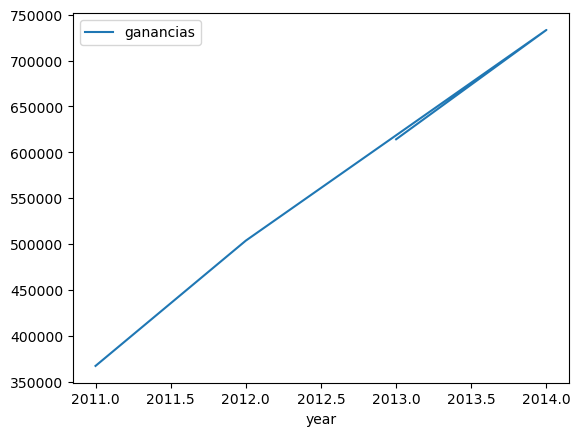

In [282]:
analisis1.plot('year', 'ganancias')

In [322]:
dwh_query = '''SELECT  m.municipio, m.departamento, v.ganancia, v.cantidad
FROM fact_table as v
inner join fecha as f on v.id_fecha = f.id_fecha
inner join municipio as m on v.municipio_id = m.municipio_id;'''
analisis2 = pd.read_sql(dwh_query, postgres_driver1, index_col='municipio')
analisis2.head()

,departamento,ganancia,cantidad
municipio,,,
Guatemala,Guatemala,45.6,3
Santa Catarina Pinula,Guatemala,907.2,8
Santa Catarina Pinula,Guatemala,540.8,2
Santa Catarina Pinula,Guatemala,49.6,4
Santa Catarina Pinula,Guatemala,114.4,2


In [323]:
import plotly.express as px

In [325]:
fig = px.treemap(analisis2, path=[px.Constant("VENTAS POR DEPARTAMENTO Y MUNICIPIO"), 'departamento','cantidad'],
color_continuous_scale='RdBu')
fig.show()

In [320]:
dwh_query = '''SELECT p.subcategoria, sum(v.ganancia) as ganancias
FROM fact_table as v
inner join producto as p on v.producto_id = p.producto_id
group by p.subcategoria;'''
analisis3 = pd.read_sql(dwh_query, postgres_driver1, index_col="subcategoria")
analisis3

,ganancias
subcategoria,
Electrodomésticos,261481.4800
Máquinas,23556.4600
Librerías,249493.9200
Accesorios,270081.3800
Teléfonos,301774.8800
Mesas,-123058.5200
Almacenamiento,162085.4000
Carpetas,53318.4400
Sobres,62854.0400


<AxesSubplot:ylabel='subcategoria'>

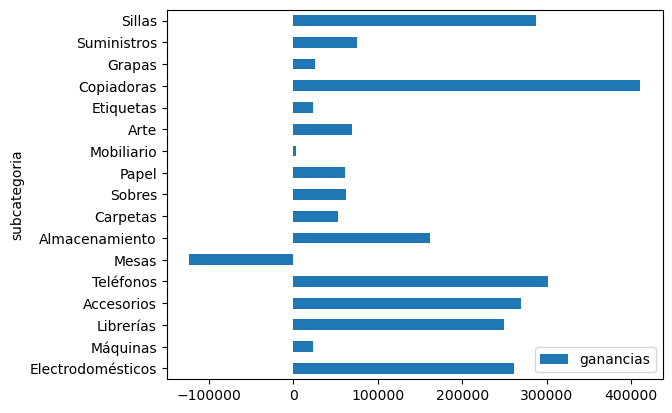

In [321]:
analisis3.plot(kind = 'barh')


In [329]:
dwh_query = '''select p.nombre_del_producto, sum(v.ganancia)/sum(cantidad) as ganancia_neta
FROM fact_table as v
inner join producto as p on v.producto_id = p.producto_id
group by p.nombre_del_producto
order by ganancia_neta asc 
FETCH FIRST 20 ROWS only;'''
analisis4 = pd.read_sql(dwh_query, postgres_driver1, index_col='nombre_del_producto')
analisis4.head()

,ganancia_neta
nombre_del_producto,
"Chromcraft Mesa de conferencias, Negro",-2967.26
"Lesro Mesa de conferencias, Blanco",-2579.46
"Lesro Mesa de ordenador, Negro",-1998.92
"Bevis Mesa de ordenador, Negro",-1879.36
"Chromcraft Mesa redonda, Rectangular",-1672.86


<AxesSubplot:ylabel='nombre_del_producto'>

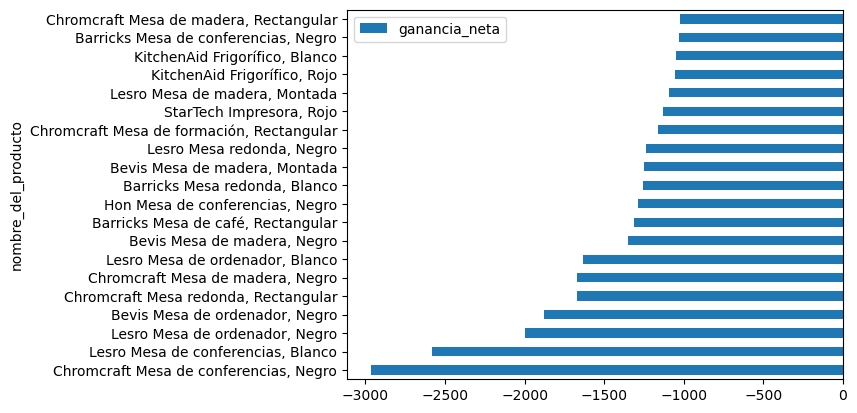

In [327]:
analisis4.plot(kind = 'barh')

In [331]:
dwh_query = '''select p.nombre_del_producto, sum(v.ganancia)/sum(cantidad) as ganancia_neta
FROM fact_table as v
inner join producto as p on v.producto_id = p.producto_id
group by p.nombre_del_producto
order by ganancia_neta desc 
FETCH FIRST 20 ROWS only;'''
analisis5 = pd.read_sql(dwh_query, postgres_driver1, index_col='nombre_del_producto')
analisis5.head()

,ganancia_neta
nombre_del_producto,
"Motorola Cargador, Al por mayor",1756.800000
"Breville Horno, Negro",1720.200000
"Nokia Cargador, Azul",1653.600000
"Bevis Mesa de madera, Blanco",1571.600000
"Hoover Horno, Blanco",1565.344444


<AxesSubplot:ylabel='nombre_del_producto'>

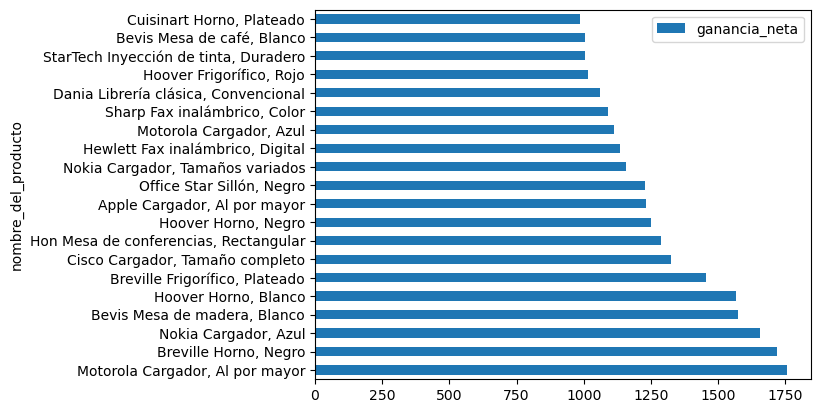

In [332]:
analisis5.plot(kind = 'barh')